In [325]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [326]:
train_data_path = os.path.join(os.getcwd(), 'Data/Data_train/') 

# Read image data and translate into numpy array
fruit_train_dict = {'Carambula': 0, 'Lychee': 0, 'Pear': 0}
fruit_train_dict['Carambula'] = len(os.listdir(train_data_path + 'Carambula'))
fruit_train_dict['Lychee'] = len(os.listdir(train_data_path + 'Lychee'))
fruit_train_dict['Pear'] = len(os.listdir(train_data_path + 'Pear'))
print(fruit_train_dict)
print('I will set 80% for the training, 20% for the validation')
fruit_data_0 = []
fruit_data_1 = []
fruit_data_2 = []
for i, k in enumerate(fruit_train_dict.keys()):
    # print(i)
    # print(k)
    for name in os.listdir(train_data_path + k):
        img = Image.open(train_data_path + k + '/' + name)
        img = img.convert('L')
        if i == 0: # 1st fruit
            fruit_data_0.append(np.array(img).flatten())
        elif i == 1: # 2nd fruit
            fruit_data_1.append(np.array(img).flatten())
        elif i == 2: # 3rd fruit
            fruit_data_2.append(np.array(img).flatten())
# print(len(fruit_data_0))
train_val_ratio = int(490 * 0.2)
print('I have used the stratified concept to handle my dataset.')

np.random.shuffle(fruit_data_0)
np.random.shuffle(fruit_data_1)
np.random.shuffle(fruit_data_2)

X_train = fruit_data_0[train_val_ratio:] + fruit_data_1[train_val_ratio:] + fruit_data_2[train_val_ratio:]
X_val = fruit_data_0[0:train_val_ratio] + fruit_data_1[0:train_val_ratio] + fruit_data_2[0:train_val_ratio]
print(f'nums of samples in training set: {len(X_train)}\nnums of samples in validation set: {len(X_val)}')
y_train = [0] * (len(fruit_data_0) - train_val_ratio) + [1] * (len(fruit_data_1) - train_val_ratio) + [2] * (len(fruit_data_2) - train_val_ratio)
y_val = [0] * train_val_ratio + [1] * train_val_ratio + [2] * train_val_ratio

{'Carambula': 490, 'Lychee': 490, 'Pear': 490}
I will set 80% for the training, 20% for the validation
I have used the stratified concept to handle my dataset.
nums of samples in training set: 1176
nums of samples in validation set: 294


In [327]:
# Read test data
test_data_path = os.path.join(os.getcwd(), 'Data/Data_test/')
fruit_test_dict = {'Carambula': 0, 'Lychee': 0, 'Pear': 0}
fruit_test_dict['Carambula'] = len(os.listdir(test_data_path + 'Carambula'))
fruit_test_dict['Lychee'] = len(os.listdir(test_data_path + 'Lychee'))
fruit_test_dict['Pear'] = len(os.listdir(test_data_path + 'Pear'))

fruit_data_0 = []
fruit_data_1 = []
fruit_data_2 = []

for i, k in enumerate(fruit_test_dict.keys()):
    for name in os.listdir(test_data_path + k):
        img = Image.open(test_data_path + k + '/' + name)
        img = img.convert('L')
        if i == 0: # 1st fruit
            fruit_data_0.append(np.array(img).flatten())
        elif i == 1: # 2nd fruit
            fruit_data_1.append(np.array(img).flatten())
        elif i == 2: # 3rd fruit
            fruit_data_2.append(np.array(img).flatten())
X_test = fruit_data_0 + fruit_data_1 + fruit_data_2
y_test = [0] * len(fruit_data_0) + [1] * len(fruit_data_1) + [2] * len(fruit_data_2)

In [328]:
# Do standardization
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import MaxAbsScaler
sc = StandardScaler()
# sc = MinMaxScaler()
# sc = MaxAbsScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)
print(X_train_std.shape, X_val_std.shape, X_test_std.shape)

# Perform PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

train_bias = np.ones((X_train_pca.shape[0], 1))
val_bias = np.ones((X_val_pca.shape[0], 1))
test_bias = np.ones((X_test_pca.shape[0], 1))
X_train_pca = np.concatenate((X_train_pca, train_bias), axis=1)
X_val_pca = np.concatenate((X_val_pca, val_bias), axis=1)
X_test_pca = np.concatenate((X_test_pca, test_bias), axis=1)
print('The shapes after concatenate bias column: ')
print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


(1176, 1024) (294, 1024) (498, 1024)
The shapes after concatenate bias column: 
(1176, 3) (294, 3) (498, 3)


In [329]:
# Define some useful math function
def softmax(x):
    exp_x = np.exp(x)
    # return exp_x / exp_x.sum()
    return exp_x / np.sum(exp_x, axis=0)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dev_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# refer from this link to use He initialization
# https://datascience-enthusiast.com/DL/Improving-DeepNeural-Networks-Initialization.html
def Linear(input_dim, output_dim):
    """
        Initialize a FC layer(using He initialization).
        Note: In my design, I fuse the bias term into the weight matrix
    """
    params = {'W': np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)}
    return params

# define the drawing function for decision boundary
def plot_decision_regions(X, y, classifier, resolution=0.1):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    a = np.array([xx1.ravel(), xx2.ravel(), np.ones(xx1.ravel().shape)])
    Z = classifier.predict(a.T)
    comm = np.zeros((Z.shape[0]))
    for i in range(0, Z.shape[0]):
        comm[i] = Z[i,:].argmax()
    Z = comm.reshape(xx1.shape)  

    # Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
    # plt.title('Decision region plot')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')

In [330]:
class two_layer_NN:
    def __init__(self, lr=0.01, input_dim=3, hidden_1=8):
        self.lr = lr
        self.input_dim = input_dim
        self.output_dim = 3 # since there are 3 labels to predict
        self.hidden_1 = hidden_1
        self.fc1 = Linear(self.input_dim, self.hidden_1)
        self.fc2 = Linear(self.hidden_1, self.output_dim)
        self.tensors = {} # store the tensor value when forwarding
        self.grad = {} # store the gradient value from back prop.
        
        self.m_dw1 = 0
        self.v_dw1 = 0
        self.m_dw2 = 0
        self.v_dw2 = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8


    def forward(self, data):
        self.tensors['x'] = data
        # print('x ', self.tensors['x'].shape)

        self.tensors['z1'] = self.tensors['x'].dot(self.fc1['W'])
        # print('z1 ', self.tensors['z1'].shape)
        
        self.tensors['act1'] = sigmoid(self.tensors['z1'])
        # print('act1 ', self.tensors['act1'].shape)
        
        self.tensors['z2'] = self.tensors['act1'].dot(self.fc2['W'])
        # print('z2 ', self.tensors['z2'].shape)
        
        self.tensors['y'] = softmax(self.tensors['z2'])
        # print('y ', self.tensors['y'].shape)
        
        return self.tensors['y']

    def backward(self, loss_bp):
        '''
            Implement backward prop. algorithm.
        '''
        # compute gradient
        ### Phase 1 to cal dW2
        dY = loss_bp.reshape(-1, 1)
        dA1 = self.tensors['act1'].reshape(1, -1)
        # this shape should be the same as self.fc2['W']
        self.grad['dW2'] = np.dot(dY, dA1).T
        # print('dw2', self.grad['dW2'].shape)
        
        ### Phase 2 to cal dW1
        d_Y2 = np.dot(dY.T, self.fc2['W'].T)
        d_sig = dev_sigmoid(self.tensors['z1'])
        d_Y1 = np.multiply(d_Y2, d_sig)
        x = self.tensors['x'].reshape(1, -1)
        # this shape should be the same as self.fc1['W']
        self.grad['dW1'] = np.dot(x.T, d_Y1)
        # print('dw1', self.grad['dW1'].shape)
        return self.grad

    def update_model(self, t=0, use_opt=False):
        # update model
        if use_opt == True:
            ## momentum beta 1
            self.m_dw1 = self.beta1 * self.m_dw1 + (1 - self.beta1) * self.grad['dW1']
            self.m_dw2 = self.beta1 * self.m_dw2 + (1 - self.beta1) * self.grad['dW2']

            ## rms beta 2
            self.v_dw1 = self.beta2 * self.v_dw1 + (1 - self.beta2) * (self.grad['dW1']**2)
            self.v_dw2 = self.beta2 * self.v_dw2 + (1 - self.beta2) * (self.grad['dW2']**2)

            ## bias correction
            m_dw1_corr = self.m_dw1 / (1 - self.beta1 ** t)
            v_dw1_corr = self.v_dw1 / (1 - self.beta2 ** t)
            m_dw2_corr = self.m_dw2 / (1 - self.beta1 ** t)
            v_dw2_corr = self.v_dw2 / (1 - self.beta2 ** t)

            ## update weights and biases
            self.fc1['W'] -= self.lr * (m_dw1_corr / (np.sqrt(v_dw1_corr) + self.eps))
            self.fc2['W'] -= self.lr * (m_dw2_corr / (np.sqrt(v_dw2_corr) + self.eps))
        else:
            self.fc2['W'] -= self.lr * self.grad['dW2']
            self.fc1['W'] -= self.lr * self.grad['dW1']
    
    def loss_forward(self, pred, y):
        '''
            Implement cross entropy loss forward pass.
        '''
        loss = 0
        for i in range(len(pred)):
            loss -= y[i] * np.log2(pred[i])
        return loss
    
    def loss_backward(self, pred, y):
        '''
            Implement cross entropy loss combined softmax backward pass.
        '''
        return pred - y

    def predict(self, data):
        res = []
        for item in data:
            res.append(self.forward(item))
        return np.array(res)

In [331]:
# Define training function for reusability
def train(use_opt=False):
    global model
    global X_train_pca
    global X_val_pca
    global X_test_pca
    global loss_rec
    global acc_rec
    global val_acc_rec
    global val_loss_rec
    global epoch
    print(f'This is {type(model)} model.')
    for it in range(1, epoch + 1):
        # minibatches SGD (i.e. batch_size = 1)
        cul_loss = 0
        acc = 0
        for i in range(X_train_pca.shape[0]):
            idx = np.random.randint(0, X_train_pca.shape[0])
            train_sample = X_train_pca[idx]
            y = y_train[idx]
            if y == 0:
                y = np.array([1, 0, 0])
            elif y == 1:
                y = np.array([0, 1, 0])
            elif y == 2:
                y = np.array([0, 0, 1])
            y_p = model.forward(train_sample)
            cost = model.loss_forward(y_p, y)
            loss_bp = model.loss_backward(y_p, y)
            grad = model.backward(loss_bp)
            model.update_model(it, use_opt=use_opt)
            # culmulate the loss
            cul_loss += cost

        for i in range(X_train_pca.shape[0]):
            prediction = model.forward(X_train_pca[i])
            if np.argmax(prediction) == y_train[i]:
                acc += 1
        
        # do validation here
        acc_val = 0
        cul_val_loss = 0
        for i in range(X_val_pca.shape[0]):
            val_sample = X_val_pca[i]
            y = y_val[i]
            if y == 0:
                y = np.array([1, 0, 0])
            elif y == 1:
                y = np.array([0, 1, 0])
            elif y == 2:
                y = np.array([0, 0, 1])
            prediction = model.forward(val_sample)
            val_loss = model.loss_forward(prediction, y)
            cul_val_loss += val_loss
            if np.argmax(prediction) == y_val[i]:
                acc_val += 1
        
        print(f'epoch: {it}, loss: {cul_loss}, Training acc: {acc / X_train_pca.shape[0]}, Val acc: {acc_val / X_val_pca.shape[0]}')
        acc_rec.append((acc / X_train_pca.shape[0]))
        loss_rec.append(cul_loss / X_train_pca.shape[0])
        val_acc_rec.append((acc_val / X_val_pca.shape[0]))
        val_loss_rec.append(cul_val_loss / X_val_pca.shape[0])

    print('-'*80)
    # testing
    acc_test = 0
    for i in range(X_test_pca.shape[0]):
        test_sample = X_test_pca[i]
        prediction = model.forward(test_sample)
        if np.argmax(prediction) == y_test[i]:
            acc_test += 1

    print(f'Test acc: {acc_test / X_test_pca.shape[0]}')


##### Training setting: hidden_num_1 = 5, lr = 0.0003, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 2806.1515400064523, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 2, loss: 2360.442960113327, Training acc: 0.3681972789115646, Val acc: 0.36394557823129253
epoch: 3, loss: 1988.823366914649, Training acc: 0.4421768707482993, Val acc: 0.4557823129251701
epoch: 4, loss: 1900.7100544845148, Training acc: 0.467687074829932, Val acc: 0.46258503401360546
epoch: 5, loss: 1750.4973520151152, Training acc: 0.4719387755102041, Val acc: 0.47278911564625853
epoch: 6, loss: 1714.4611392349293, Training acc: 0.4804421768707483, Val acc: 0.48639455782312924
epoch: 7, loss: 1618.0599702387487, Training acc: 0.5051020408163265, Val acc: 0.5136054421768708
epoch: 8, loss: 1524.1816174698313, Training acc: 0.516156462585034, Val acc: 0.5238095238095238
epoch: 9, loss: 1460.1890188987384, Training acc: 0.5229591836734694, Val acc: 0.5374149659863946
epoch: 10, loss: 1431.5688474358471, Training acc: 0.5654761904761905, 

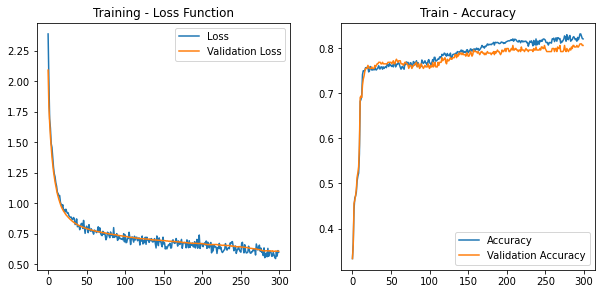

Draw decision region plots below!


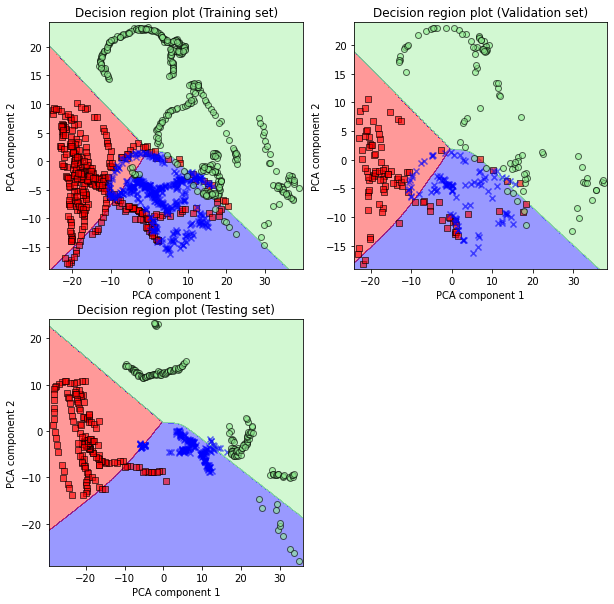

In [332]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
is_use_opt = False

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 5, lr = 0.001, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1730.5327174793852, Training acc: 0.6301020408163265, Val acc: 0.6632653061224489
epoch: 2, loss: 1482.3570342247967, Training acc: 0.7329931972789115, Val acc: 0.7687074829931972
epoch: 3, loss: 1402.956583541819, Training acc: 0.7304421768707483, Val acc: 0.7517006802721088
epoch: 4, loss: 1324.2755775724318, Training acc: 0.7253401360544217, Val acc: 0.7278911564625851
epoch: 5, loss: 1250.734456123215, Training acc: 0.7227891156462585, Val acc: 0.717687074829932
epoch: 6, loss: 1250.2642566235274, Training acc: 0.7380952380952381, Val acc: 0.7346938775510204
epoch: 7, loss: 1198.943989151316, Training acc: 0.7329931972789115, Val acc: 0.7108843537414966
epoch: 8, loss: 1180.1299153024559, Training acc: 0.7380952380952381, Val acc: 0.7108843537414966
epoch: 9, loss: 1162.8038188793785, Training acc: 0.7397959183673469, Val acc: 0.717687074829932
epoch: 10, loss: 1138.7282141397452, Training acc: 0.7534013605442177, Val a

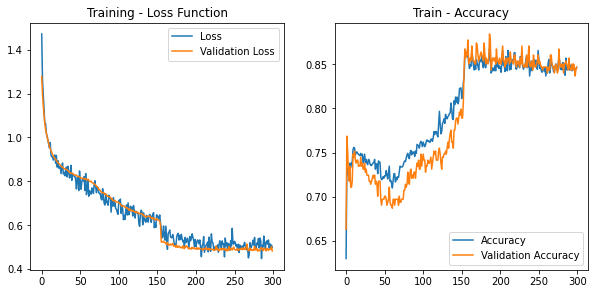

Draw decision region plots below!


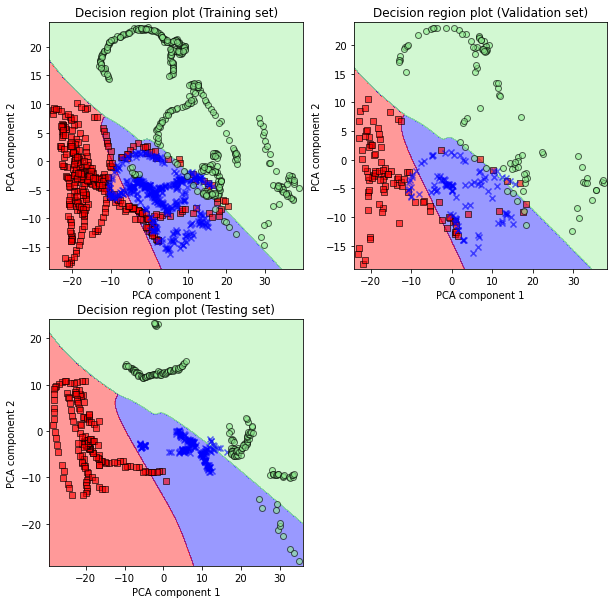

In [333]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
is_use_opt = False

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 15, lr = 0.0003, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 2879.5817282087473, Training acc: 0.3171768707482993, Val acc: 0.3163265306122449
epoch: 2, loss: 2210.333137521452, Training acc: 0.3647959183673469, Val acc: 0.3707482993197279
epoch: 3, loss: 1794.624589534024, Training acc: 0.5246598639455783, Val acc: 0.5170068027210885
epoch: 4, loss: 1546.753680418501, Training acc: 0.6862244897959183, Val acc: 0.6564625850340136
epoch: 5, loss: 1405.7218377720583, Training acc: 0.6904761904761905, Val acc: 0.673469387755102
epoch: 6, loss: 1289.4155746899396, Training acc: 0.6964285714285714, Val acc: 0.673469387755102
epoch: 7, loss: 1196.9052760176544, Training acc: 0.6981292517006803, Val acc: 0.6700680272108843
epoch: 8, loss: 1166.314898517609, Training acc: 0.782312925170068, Val acc: 0.7721088435374149
epoch: 9, loss: 1065.7476232376594, Training acc: 0.7814625850340136, Val acc: 0.7721088435374149
epoch: 10, loss: 1106.2318100842485, Training acc: 0.7857142857142857, Val acc

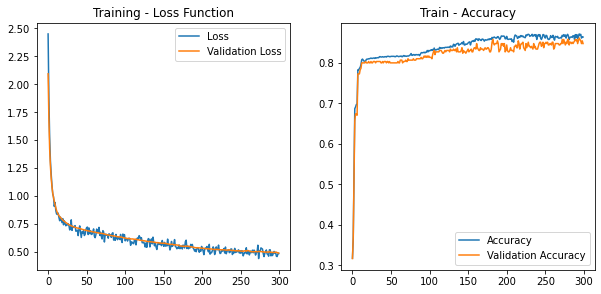

Draw decision region plots below!


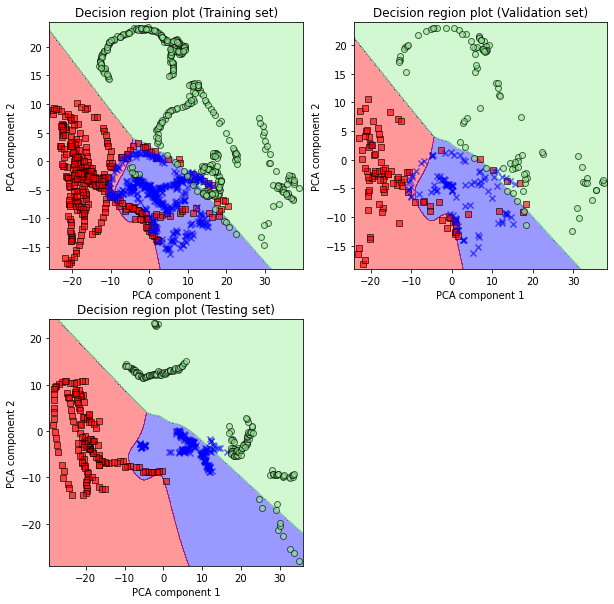

In [334]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
is_use_opt = False

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 15, lr = 0.001, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1592.7569889764675, Training acc: 0.7006802721088435, Val acc: 0.7142857142857143
epoch: 2, loss: 1263.0172082939803, Training acc: 0.7414965986394558, Val acc: 0.7551020408163265
epoch: 3, loss: 1077.9927690987734, Training acc: 0.7695578231292517, Val acc: 0.782312925170068
epoch: 4, loss: 1080.9353164528916, Training acc: 0.7729591836734694, Val acc: 0.782312925170068
epoch: 5, loss: 961.4260635461369, Training acc: 0.7755102040816326, Val acc: 0.7857142857142857
epoch: 6, loss: 976.8869763926436, Training acc: 0.7797619047619048, Val acc: 0.7891156462585034
epoch: 7, loss: 947.4514443244007, Training acc: 0.7933673469387755, Val acc: 0.7891156462585034
epoch: 8, loss: 950.6995900831269, Training acc: 0.7865646258503401, Val acc: 0.7857142857142857
epoch: 9, loss: 913.3305113845506, Training acc: 0.7848639455782312, Val acc: 0.7857142857142857
epoch: 10, loss: 865.054153597956, Training acc: 0.7993197278911565, Val acc: 

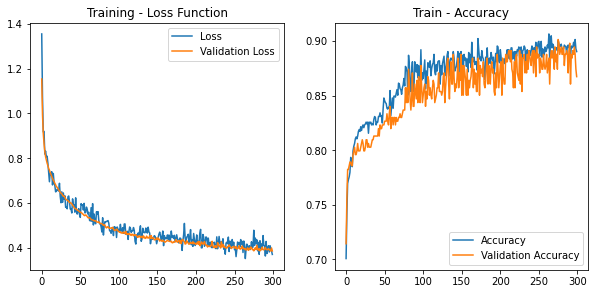

Draw decision region plots below!


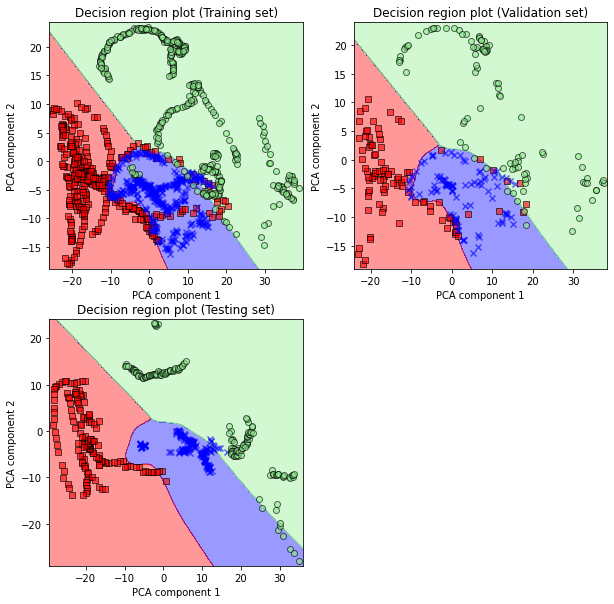

In [335]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
is_use_opt = False

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 50, lr = 0.0003, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1883.5995169412479, Training acc: 0.6505102040816326, Val acc: 0.6224489795918368
epoch: 2, loss: 1360.1124242357903, Training acc: 0.7091836734693877, Val acc: 0.7074829931972789
epoch: 3, loss: 1147.9200476530982, Training acc: 0.7559523809523809, Val acc: 0.7551020408163265
epoch: 4, loss: 1060.3349494951117, Training acc: 0.7593537414965986, Val acc: 0.7619047619047619
epoch: 5, loss: 1055.7284811964707, Training acc: 0.7542517006802721, Val acc: 0.7551020408163265
epoch: 6, loss: 958.2373770561144, Training acc: 0.7670068027210885, Val acc: 0.7687074829931972
epoch: 7, loss: 986.7524615662871, Training acc: 0.7517006802721088, Val acc: 0.7653061224489796
epoch: 8, loss: 980.7078068316619, Training acc: 0.7610544217687075, Val acc: 0.7517006802721088
epoch: 9, loss: 912.7866936544825, Training acc: 0.7602040816326531, Val acc: 0.7687074829931972
epoch: 10, loss: 943.2927534675588, Training acc: 0.7551020408163265, Val a

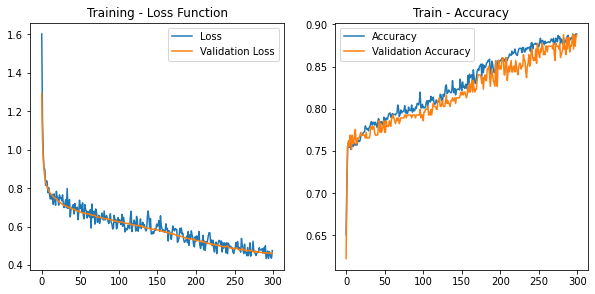

Draw decision region plots below!


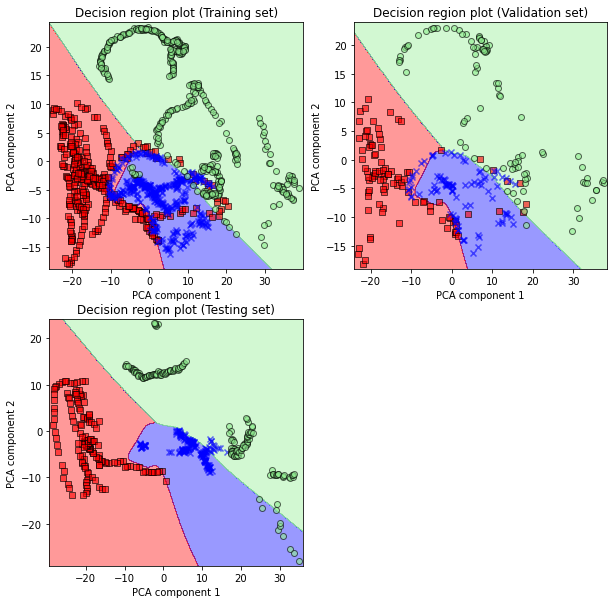

In [336]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
is_use_opt = False

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 50, lr = 0.001, use traditional SGD

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1343.938613430093, Training acc: 0.7695578231292517, Val acc: 0.7755102040816326
epoch: 2, loss: 895.6398155143775, Training acc: 0.7678571428571429, Val acc: 0.782312925170068
epoch: 3, loss: 865.219322115357, Training acc: 0.8052721088435374, Val acc: 0.8027210884353742
epoch: 4, loss: 788.3954372528567, Training acc: 0.814625850340136, Val acc: 0.8061224489795918
epoch: 5, loss: 810.5945510507635, Training acc: 0.7908163265306123, Val acc: 0.8027210884353742
epoch: 6, loss: 791.1940191442375, Training acc: 0.8154761904761905, Val acc: 0.8095238095238095
epoch: 7, loss: 781.7567298907476, Training acc: 0.8137755102040817, Val acc: 0.8095238095238095
epoch: 8, loss: 727.7657969034962, Training acc: 0.8129251700680272, Val acc: 0.8061224489795918
epoch: 9, loss: 725.9159268188948, Training acc: 0.8188775510204082, Val acc: 0.8129251700680272
epoch: 10, loss: 724.5248214988417, Training acc: 0.8205782312925171, Val acc: 0.81

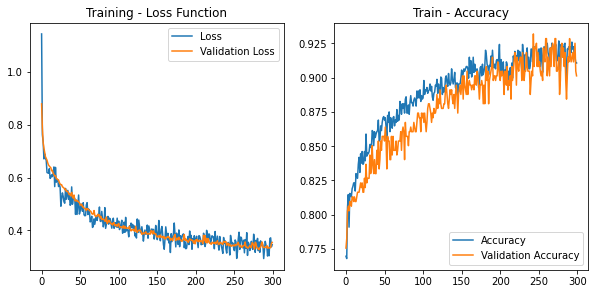

Draw decision region plots below!


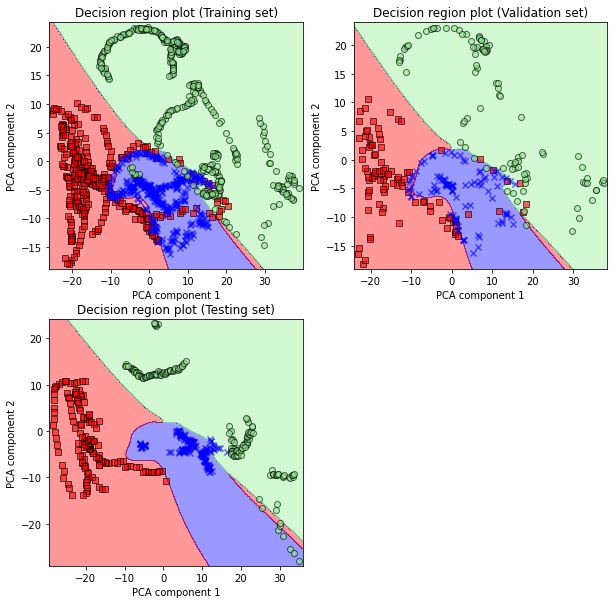

In [337]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
is_use_opt = False

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

print('Draw learning curves below!')
# draw learning curve
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 5, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1615.093731844331, Training acc: 0.5867346938775511, Val acc: 0.6020408163265306
epoch: 2, loss: 1571.3904486022875, Training acc: 0.5901360544217688, Val acc: 0.6020408163265306
epoch: 3, loss: 1504.7096919585854, Training acc: 0.6003401360544217, Val acc: 0.608843537414966
epoch: 4, loss: 1443.9003284547387, Training acc: 0.6045918367346939, Val acc: 0.6190476190476191
epoch: 5, loss: 1435.51044381947, Training acc: 0.6079931972789115, Val acc: 0.6224489795918368
epoch: 6, loss: 1407.8409298834606, Training acc: 0.6130952380952381, Val acc: 0.6224489795918368
epoch: 7, loss: 1404.8553582583204, Training acc: 0.6173469387755102, Val acc: 0.6326530612244898
epoch: 8, loss: 1369.2723801200573, Training acc: 0.625, Val acc: 0.6428571428571429
epoch: 9, loss: 1357.9155354921645, Training acc: 0.6394557823129252, Val acc: 0.6496598639455783
epoch: 10, loss: 1274.8529274100756, Training acc: 0.6513605442176871, Val acc: 0.659863

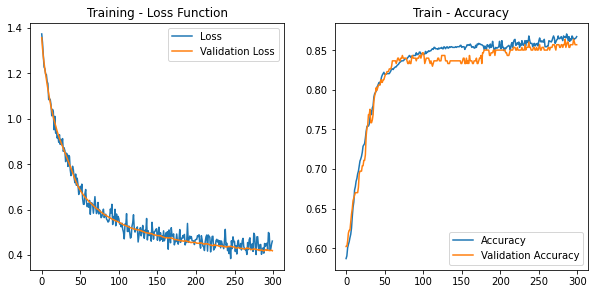

Draw decision region plots below!


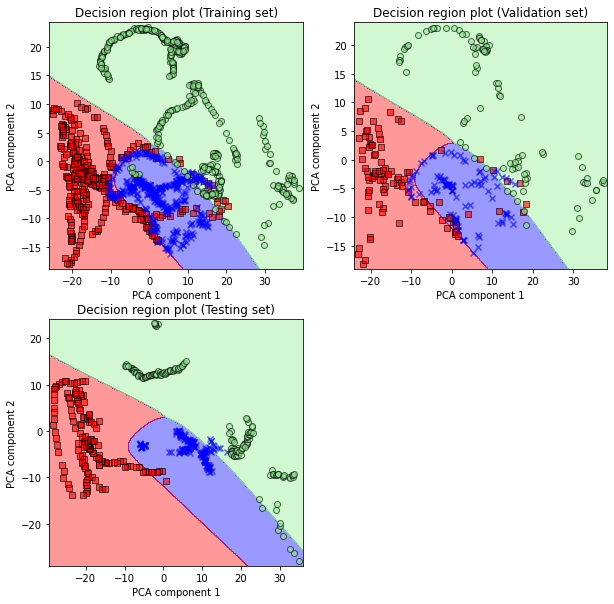

In [338]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
is_use_opt = True

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 5, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 2096.6062407820073, Training acc: 0.36989795918367346, Val acc: 0.3673469387755102
epoch: 2, loss: 1802.692017727769, Training acc: 0.47874149659863946, Val acc: 0.48299319727891155
epoch: 3, loss: 1657.1784239175847, Training acc: 0.4914965986394558, Val acc: 0.4965986394557823
epoch: 4, loss: 1556.950267780577, Training acc: 0.5051020408163265, Val acc: 0.5102040816326531
epoch: 5, loss: 1476.5348332640615, Training acc: 0.6445578231292517, Val acc: 0.6530612244897959
epoch: 6, loss: 1401.1327774651534, Training acc: 0.6471088435374149, Val acc: 0.6598639455782312
epoch: 7, loss: 1348.8662639552301, Training acc: 0.6539115646258503, Val acc: 0.6564625850340136
epoch: 8, loss: 1287.021178324758, Training acc: 0.6921768707482994, Val acc: 0.6836734693877551
epoch: 9, loss: 1267.6196419201942, Training acc: 0.7159863945578231, Val acc: 0.7006802721088435
epoch: 10, loss: 1193.5728524307585, Training acc: 0.7355442176870748, 

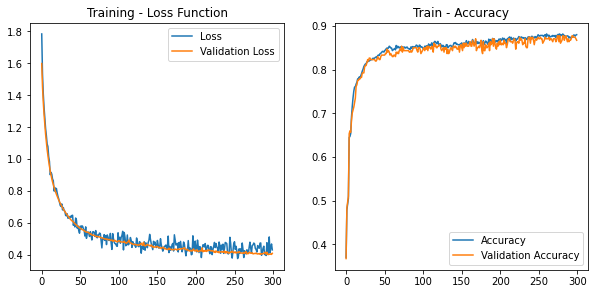

Draw decision region plots below!


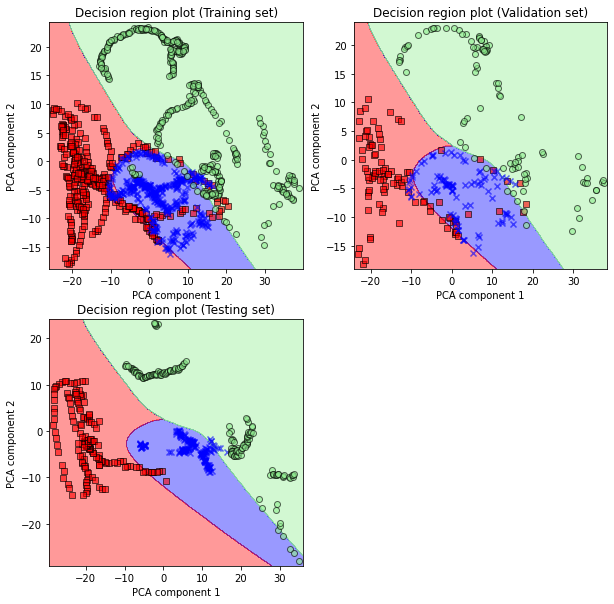

In [339]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
is_use_opt = True

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 15, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1604.0651412268028, Training acc: 0.6386054421768708, Val acc: 0.6258503401360545
epoch: 2, loss: 1295.5827655283756, Training acc: 0.6947278911564626, Val acc: 0.7006802721088435
epoch: 3, loss: 1174.01025507298, Training acc: 0.8010204081632653, Val acc: 0.7959183673469388
epoch: 4, loss: 1099.7261864559905, Training acc: 0.8095238095238095, Val acc: 0.7993197278911565
epoch: 5, loss: 1087.459928021052, Training acc: 0.8052721088435374, Val acc: 0.8129251700680272
epoch: 6, loss: 1030.389449822633, Training acc: 0.7857142857142857, Val acc: 0.7959183673469388
epoch: 7, loss: 1029.0331161494405, Training acc: 0.7780612244897959, Val acc: 0.7857142857142857
epoch: 8, loss: 962.4254236786986, Training acc: 0.7712585034013606, Val acc: 0.7755102040816326
epoch: 9, loss: 999.9317171416182, Training acc: 0.7695578231292517, Val acc: 0.7789115646258503
epoch: 10, loss: 955.9452004448002, Training acc: 0.7712585034013606, Val acc

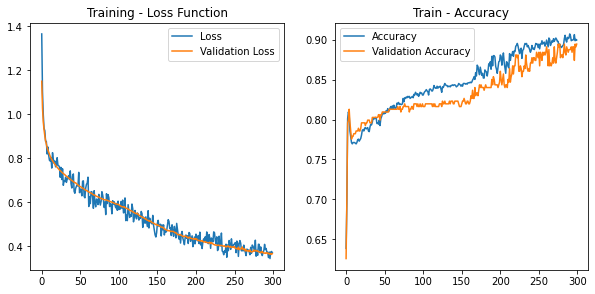

Draw decision region plots below!


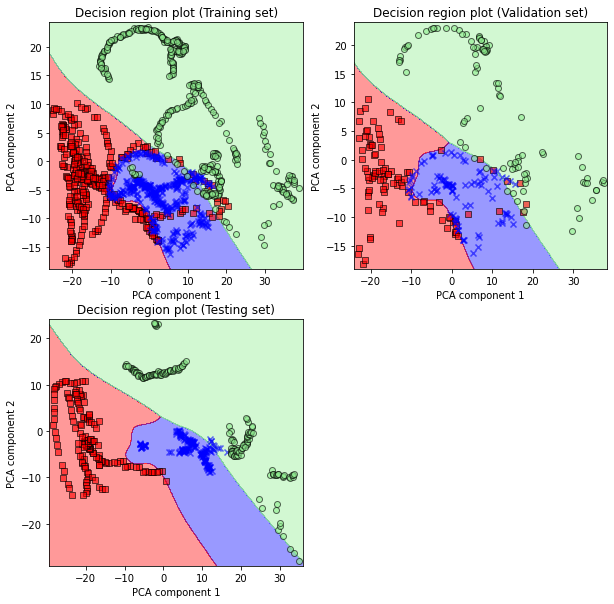

In [340]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
is_use_opt = True

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 15, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1326.2355181359435, Training acc: 0.7219387755102041, Val acc: 0.673469387755102
epoch: 2, loss: 1003.9469687351071, Training acc: 0.7687074829931972, Val acc: 0.7619047619047619
epoch: 3, loss: 941.4138880007807, Training acc: 0.7797619047619048, Val acc: 0.782312925170068
epoch: 4, loss: 900.2684255417965, Training acc: 0.7831632653061225, Val acc: 0.7891156462585034
epoch: 5, loss: 856.3466983044138, Training acc: 0.7840136054421769, Val acc: 0.7857142857142857
epoch: 6, loss: 855.7115764999668, Training acc: 0.7865646258503401, Val acc: 0.7891156462585034
epoch: 7, loss: 799.3838472836864, Training acc: 0.7908163265306123, Val acc: 0.7925170068027211
epoch: 8, loss: 833.92463245649, Training acc: 0.798469387755102, Val acc: 0.7993197278911565
epoch: 9, loss: 798.390445311885, Training acc: 0.8018707482993197, Val acc: 0.8027210884353742
epoch: 10, loss: 818.6307002782792, Training acc: 0.8001700680272109, Val acc: 0.806

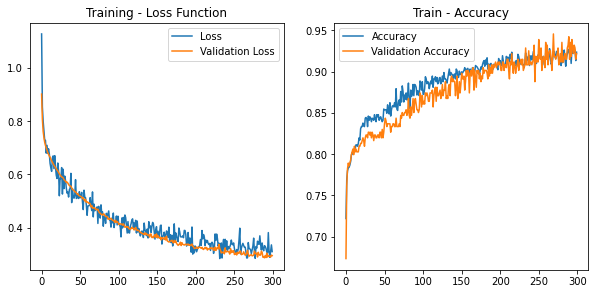

Draw decision region plots below!


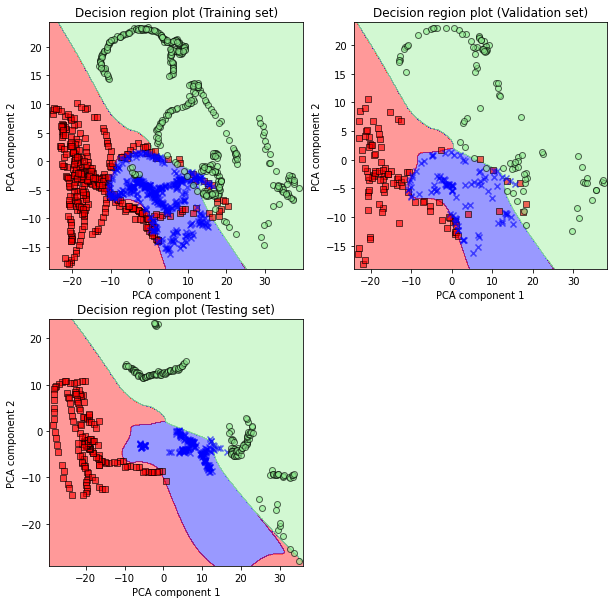

In [341]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
is_use_opt = True

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 50, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1233.8782195798183, Training acc: 0.7831632653061225, Val acc: 0.782312925170068
epoch: 2, loss: 1043.420531328136, Training acc: 0.7848639455782312, Val acc: 0.7891156462585034
epoch: 3, loss: 924.1027051293293, Training acc: 0.7865646258503401, Val acc: 0.7891156462585034
epoch: 4, loss: 919.8546708693415, Training acc: 0.7840136054421769, Val acc: 0.7857142857142857
epoch: 5, loss: 860.4329721256966, Training acc: 0.7857142857142857, Val acc: 0.7891156462585034
epoch: 6, loss: 881.8814382649849, Training acc: 0.7857142857142857, Val acc: 0.7925170068027211
epoch: 7, loss: 823.8327269618958, Training acc: 0.7865646258503401, Val acc: 0.7925170068027211
epoch: 8, loss: 815.4833738629679, Training acc: 0.7865646258503401, Val acc: 0.7891156462585034
epoch: 9, loss: 779.7022628989226, Training acc: 0.7840136054421769, Val acc: 0.7925170068027211
epoch: 10, loss: 812.1432243498951, Training acc: 0.7882653061224489, Val acc: 0

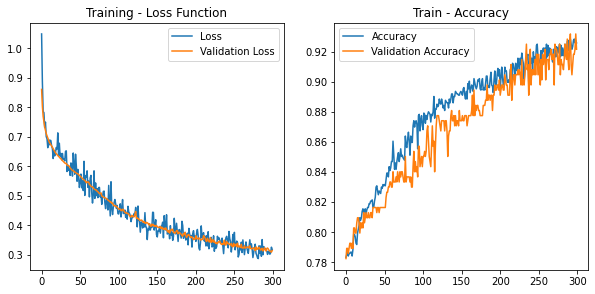

Draw decision region plots below!


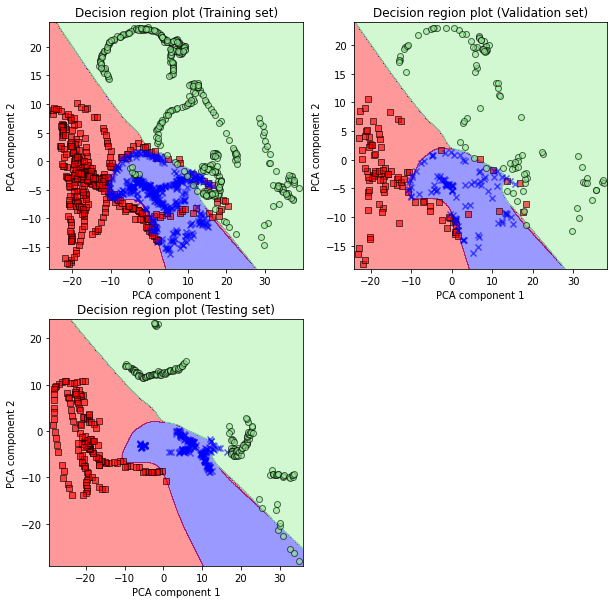

In [342]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
is_use_opt = True

model = two_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

##### Training setting: hidden_num_1 = 50, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.two_layer_NN'> model.
epoch: 1, loss: 1014.8959101370235, Training acc: 0.8027210884353742, Val acc: 0.7959183673469388
epoch: 2, loss: 882.2385114751548, Training acc: 0.7874149659863946, Val acc: 0.7925170068027211
epoch: 3, loss: 743.3197047890118, Training acc: 0.8248299319727891, Val acc: 0.8197278911564626
epoch: 4, loss: 762.7639281549276, Training acc: 0.8222789115646258, Val acc: 0.8231292517006803
epoch: 5, loss: 724.840022073308, Training acc: 0.826530612244898, Val acc: 0.8197278911564626
epoch: 6, loss: 691.6191311457887, Training acc: 0.83078231292517, Val acc: 0.8231292517006803
epoch: 7, loss: 722.730427033441, Training acc: 0.8324829931972789, Val acc: 0.8231292517006803
epoch: 8, loss: 669.3810949444867, Training acc: 0.8367346938775511, Val acc: 0.8231292517006803
epoch: 9, loss: 702.3826240253674, Training acc: 0.842687074829932, Val acc: 0.8231292517006803
epoch: 10, loss: 646.8610989771405, Training acc: 0.8367346938775511, Val acc: 0.8299

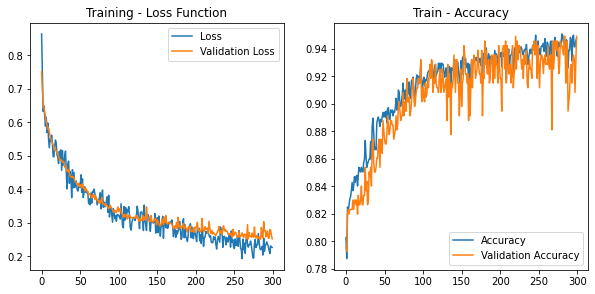

Draw decision region plots below!


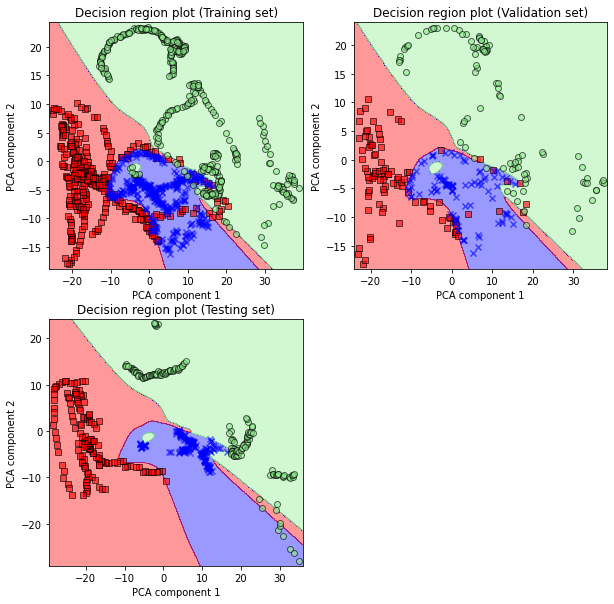

In [343]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
is_use_opt = True

model = two_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')

In [344]:
class three_layer_NN:
    def __init__(self, lr=0.01, input_dim=3, hidden_1=5, hidden_2=10):
        self.lr = lr
        self.input_dim = input_dim
        self.output_dim = 3 # since there are 3 labels to predict
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.fc1 = Linear(self.input_dim, self.hidden_1)
        self.fc2 = Linear(self.hidden_1, self.hidden_2)
        self.fc3 = Linear(self.hidden_2, self.output_dim)
        self.tensors = {} # store the tensor value when forwarding
        self.grad = {} # store the gradient value from back prop.

        self.m_dw1 = 0
        self.v_dw1 = 0
        self.m_dw2 = 0
        self.v_dw2 = 0
        self.m_dw3 = 0
        self.v_dw3 = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
    
    def forward(self, data):
        self.tensors['x'] = data

        self.tensors['z1'] = self.tensors['x'].dot(self.fc1['W'])
        
        self.tensors['act1'] = sigmoid(self.tensors['z1'])
        
        self.tensors['z2'] = self.tensors['act1'].dot(self.fc2['W'])

        self.tensors['act2'] = sigmoid(self.tensors['z2'])

        self.tensors['z3'] = self.tensors['act2'].dot(self.fc3['W'])
        
        self.tensors['y'] = softmax(self.tensors['z3'])
        
        return self.tensors['y']

    def backward(self, loss_bp):
        '''
            Implement backward prop. algorithm.
        '''
        # compute gradient

        ### Phase 1 to cal dW3
        dY = loss_bp.reshape(-1, 1)
        dA2 = self.tensors['act2'].reshape(1, -1)
        self.grad['dW3'] = np.dot(dY, dA2).T
        # print('dw3', self.grad['dW3'].shape)
        # print('fc3', self.fc3['W'].shape)

        ### Phase 2 to cal dW2
        d_Y2 = np.dot(dY.T, self.fc3['W'].T)
        d_sig_2 = dev_sigmoid(self.tensors['z2'])
        dA1 = self.tensors['act1'].reshape(1, -1)
        d_Y1 = np.multiply(d_Y2, d_sig_2)
        self.grad['dW2'] = np.dot(d_Y1.T, dA1).T
        # print('dw2', self.grad['dW2'].shape)
        # print('fc2', self.fc2['W'].shape)
        
        ### Phase 3 to cal dW1
        d_sig = dev_sigmoid(self.tensors['z1'])
        x = self.tensors['x'].reshape(1, -1)
        # print('d_sig', d_sig.shape)
        d_Y3 = np.dot(d_Y1, self.fc2['W'].T)
        self.grad['dW1'] = np.dot(np.multiply(d_Y3, d_sig).T, x).T
        return self.grad

    def update_model(self, t, use_opt=False):
        # update model
        if use_opt == True:
            ## momentum beta 1
            self.m_dw1 = self.beta1 * self.m_dw1 + (1 - self.beta1) * self.grad['dW1']
            self.m_dw2 = self.beta1 * self.m_dw2 + (1 - self.beta1) * self.grad['dW2']
            self.m_dw3 = self.beta1 * self.m_dw3 + (1 - self.beta1) * self.grad['dW3']

            ## rms beta 2
            self.v_dw1 = self.beta2 * self.v_dw1 + (1 - self.beta2) * (self.grad['dW1']**2)
            self.v_dw2 = self.beta2 * self.v_dw2 + (1 - self.beta2) * (self.grad['dW2']**2)
            self.v_dw3 = self.beta2 * self.v_dw3 + (1 - self.beta2) * (self.grad['dW3']**2)

            ## bias correction
            m_dw1_corr = self.m_dw1 / (1 - self.beta1 ** t)
            v_dw1_corr = self.v_dw1 / (1 - self.beta2 ** t)
            m_dw2_corr = self.m_dw2 / (1 - self.beta1 ** t)
            v_dw2_corr = self.v_dw2 / (1 - self.beta2 ** t)
            m_dw3_corr = self.m_dw3 / (1 - self.beta1 ** t)
            v_dw3_corr = self.v_dw3 / (1 - self.beta2 ** t)

            ## update weights and biases
            self.fc1['W'] -= self.lr * (m_dw1_corr / (np.sqrt(v_dw1_corr) + self.eps))
            self.fc2['W'] -= self.lr * (m_dw2_corr / (np.sqrt(v_dw2_corr) + self.eps))
            self.fc3['W'] -= self.lr * (m_dw3_corr / (np.sqrt(v_dw3_corr) + self.eps))
        else:
            self.fc3['W'] -= self.lr * self.grad['dW3']
            self.fc2['W'] -= self.lr * self.grad['dW2']
            self.fc1['W'] -= self.lr * self.grad['dW1']
    
    def loss_forward(self, pred, y):
        '''
            Implement cross entropy loss forward pass.
        '''
        loss = 0
        for i in range(len(pred)):
            loss -= y[i] * np.log2(pred[i])
        return loss
    
    def loss_backward(self, pred, y):
        '''
            Implement cross entropy loss combined softmax backward pass.
        '''
        return pred - y

    def predict(self, data):
        res = []
        for item in data:
            res.append(self.forward(item))
        return np.array(res)

##### Training setting: hidden_num_1 = 5, hidden_num_2 = 10, lr = 0.0003, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1701.7503738265639, Training acc: 0.5833333333333334, Val acc: 0.5952380952380952
epoch: 2, loss: 1695.2915362454341, Training acc: 0.5952380952380952, Val acc: 0.5952380952380952
epoch: 3, loss: 1680.3173097749757, Training acc: 0.6130952380952381, Val acc: 0.6122448979591837
epoch: 4, loss: 1647.2435191970096, Training acc: 0.6062925170068028, Val acc: 0.608843537414966
epoch: 5, loss: 1643.1375114074888, Training acc: 0.6207482993197279, Val acc: 0.6360544217687075
epoch: 6, loss: 1603.7435667207508, Training acc: 0.6224489795918368, Val acc: 0.6190476190476191
epoch: 7, loss: 1602.8235980594, Training acc: 0.6232993197278912, Val acc: 0.6326530612244898
epoch: 8, loss: 1588.5712659973558, Training acc: 0.6318027210884354, Val acc: 0.6428571428571429
epoch: 9, loss: 1555.507970060698, Training acc: 0.6343537414965986, Val acc: 0.6496598639455783
epoch: 10, loss: 1553.575439966532, Training acc: 0.7295918367346939, Val 

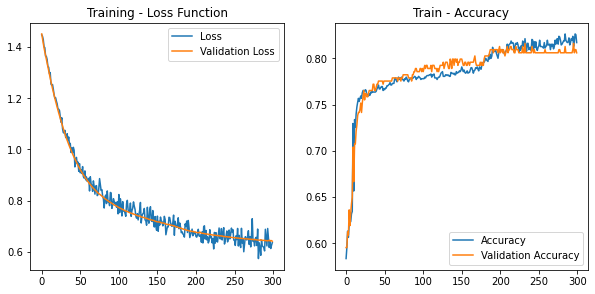

Draw decision region plots below!


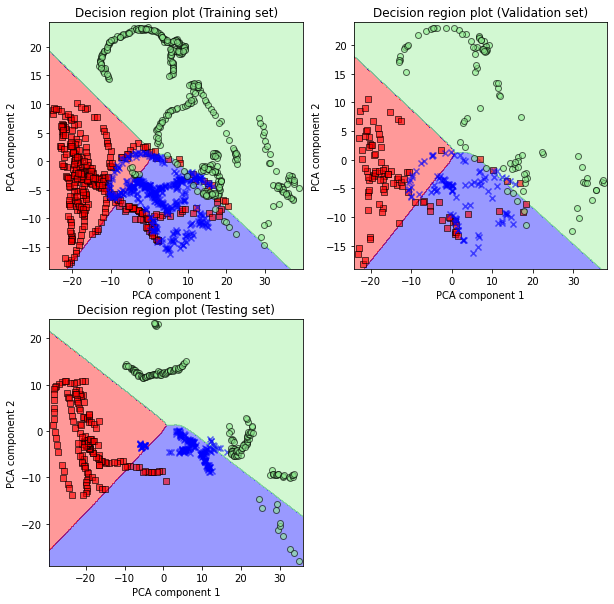

In [345]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 5, hidden_num_2 = 10, lr = 0.001, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1822.0508322957867, Training acc: 0.5306122448979592, Val acc: 0.5374149659863946
epoch: 2, loss: 1631.30027200463, Training acc: 0.6301020408163265, Val acc: 0.6360544217687075
epoch: 3, loss: 1536.5729271228279, Training acc: 0.6683673469387755, Val acc: 0.673469387755102
epoch: 4, loss: 1446.11925012013, Training acc: 0.7397959183673469, Val acc: 0.7278911564625851
epoch: 5, loss: 1410.2152761455063, Training acc: 0.7729591836734694, Val acc: 0.7619047619047619
epoch: 6, loss: 1358.1347092567823, Training acc: 0.7797619047619048, Val acc: 0.7619047619047619
epoch: 7, loss: 1301.1216987823225, Training acc: 0.7712585034013606, Val acc: 0.7585034013605442
epoch: 8, loss: 1232.4419960540306, Training acc: 0.7746598639455783, Val acc: 0.7619047619047619
epoch: 9, loss: 1199.6577508168298, Training acc: 0.7755102040816326, Val acc: 0.7619047619047619
epoch: 10, loss: 1154.6057760813278, Training acc: 0.7763605442176871, Val

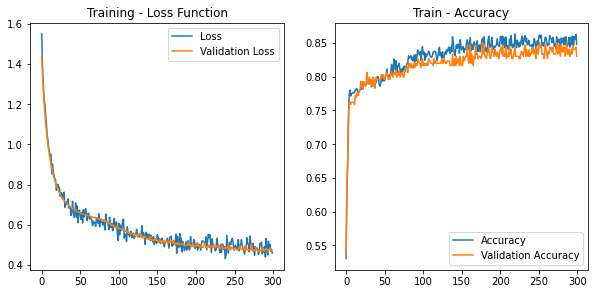

Draw decision region plots below!


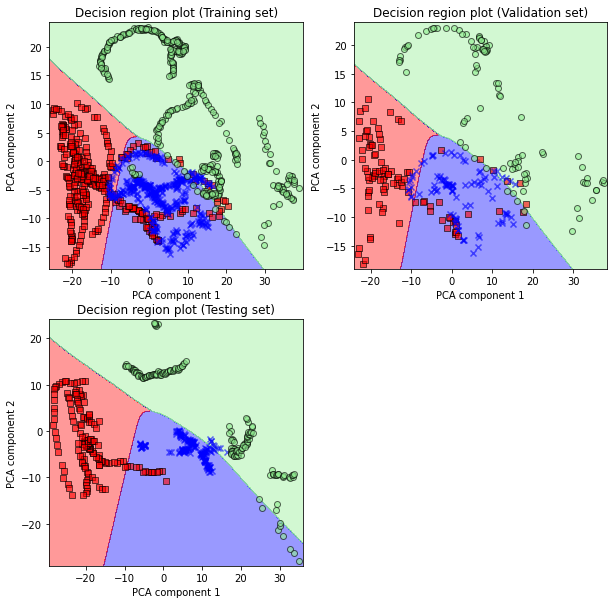

In [346]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 15, hidden_num_2 = 10, lr = 0.0003, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 2127.527787966437, Training acc: 0.5365646258503401, Val acc: 0.5238095238095238
epoch: 2, loss: 1987.1972937521011, Training acc: 0.5459183673469388, Val acc: 0.5272108843537415
epoch: 3, loss: 1818.4987139592974, Training acc: 0.5467687074829932, Val acc: 0.5374149659863946
epoch: 4, loss: 1772.928983202423, Training acc: 0.5858843537414966, Val acc: 0.5952380952380952
epoch: 5, loss: 1727.3147028673593, Training acc: 0.5875850340136054, Val acc: 0.5952380952380952
epoch: 6, loss: 1639.4678558598291, Training acc: 0.5858843537414966, Val acc: 0.5986394557823129
epoch: 7, loss: 1586.2801822683825, Training acc: 0.5756802721088435, Val acc: 0.5816326530612245
epoch: 8, loss: 1578.4125547333447, Training acc: 0.5782312925170068, Val acc: 0.5884353741496599
epoch: 9, loss: 1532.3164219409978, Training acc: 0.5969387755102041, Val acc: 0.6020408163265306
epoch: 10, loss: 1529.4162999733069, Training acc: 0.6624149659863946, 

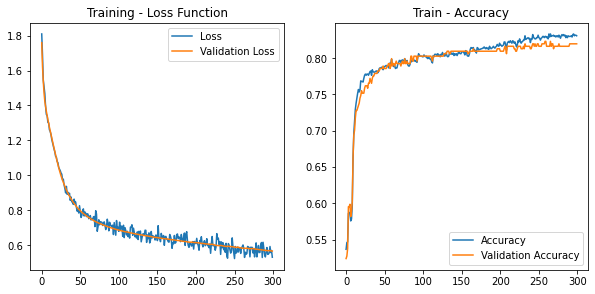

Draw decision region plots below!


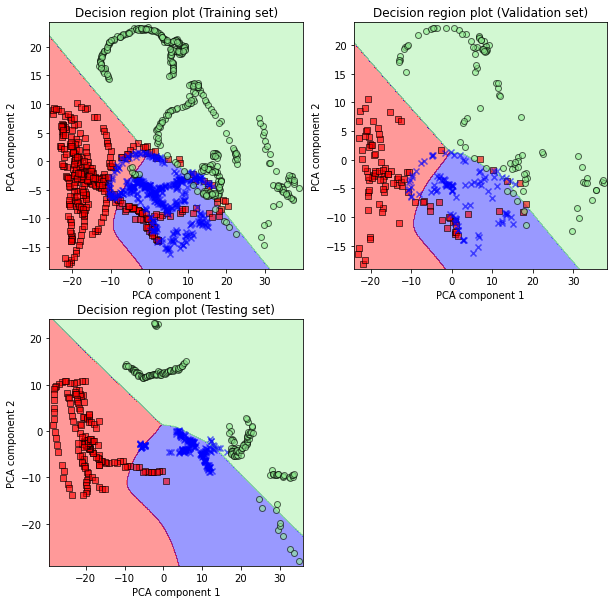

In [347]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 15, hidden_num_2 = 10, lr = 0.001, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1915.1937350776993, Training acc: 0.43112244897959184, Val acc: 0.40816326530612246
epoch: 2, loss: 1573.528239536336, Training acc: 0.7117346938775511, Val acc: 0.673469387755102
epoch: 3, loss: 1424.0368286201833, Training acc: 0.7746598639455783, Val acc: 0.7687074829931972
epoch: 4, loss: 1333.4406725697331, Training acc: 0.7653061224489796, Val acc: 0.7619047619047619
epoch: 5, loss: 1247.579987187897, Training acc: 0.7712585034013606, Val acc: 0.7619047619047619
epoch: 6, loss: 1173.0146644955082, Training acc: 0.7729591836734694, Val acc: 0.7653061224489796
epoch: 7, loss: 1112.3142686733804, Training acc: 0.7780612244897959, Val acc: 0.7755102040816326
epoch: 8, loss: 1073.1778920908841, Training acc: 0.7831632653061225, Val acc: 0.7789115646258503
epoch: 9, loss: 1001.9667011289328, Training acc: 0.7950680272108843, Val acc: 0.7959183673469388
epoch: 10, loss: 1038.189237053409, Training acc: 0.7993197278911565, 

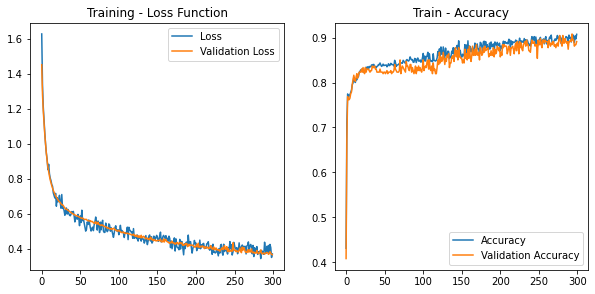

Draw decision region plots below!


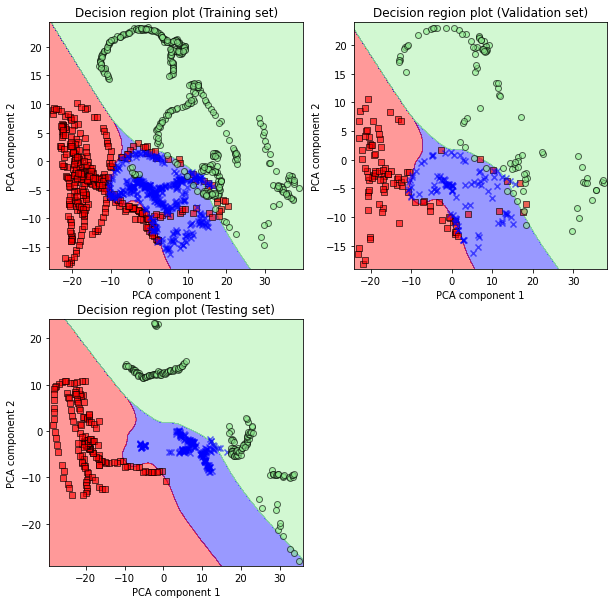

In [348]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 50, hidden_num_2 = 10, lr = 0.0003, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 2114.541096221414, Training acc: 0.33418367346938777, Val acc: 0.336734693877551
epoch: 2, loss: 1921.7591813248298, Training acc: 0.48299319727891155, Val acc: 0.48299319727891155
epoch: 3, loss: 1761.025527378008, Training acc: 0.5068027210884354, Val acc: 0.4965986394557823
epoch: 4, loss: 1683.7710971321349, Training acc: 0.5068027210884354, Val acc: 0.48639455782312924
epoch: 5, loss: 1633.4093682114028, Training acc: 0.6845238095238095, Val acc: 0.6972789115646258
epoch: 6, loss: 1590.7269363744188, Training acc: 0.7108843537414966, Val acc: 0.717687074829932
epoch: 7, loss: 1528.4198725159856, Training acc: 0.7210884353741497, Val acc: 0.7210884353741497
epoch: 8, loss: 1492.137962304269, Training acc: 0.7261904761904762, Val acc: 0.717687074829932
epoch: 9, loss: 1469.094207529355, Training acc: 0.7329931972789115, Val acc: 0.7278911564625851
epoch: 10, loss: 1435.9100227951922, Training acc: 0.7414965986394558, V

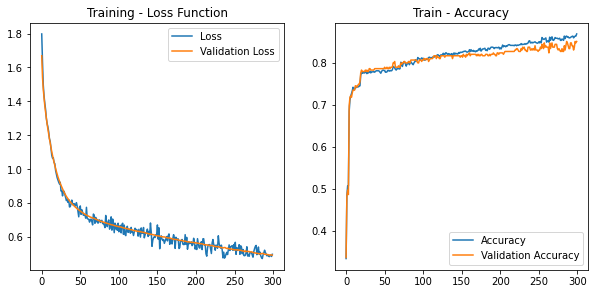

Draw decision region plots below!


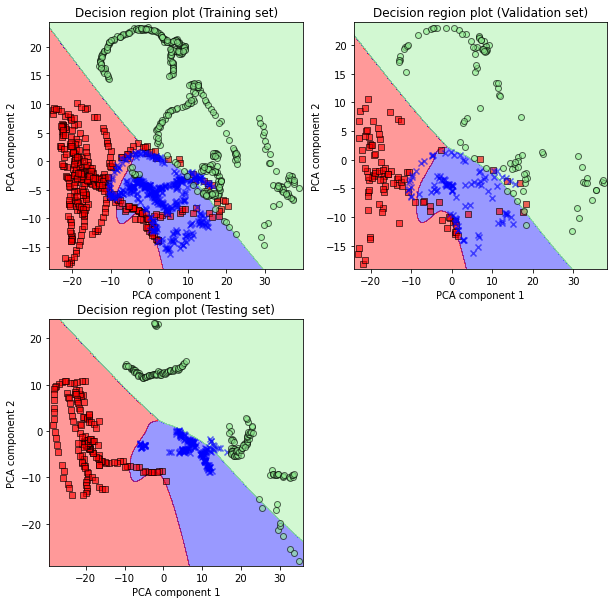

In [349]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 50, hidden_num_2 = 10, lr = 0.001, use traditional SGD

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1955.1582370786186, Training acc: 0.407312925170068, Val acc: 0.42857142857142855
epoch: 2, loss: 1571.1621172311516, Training acc: 0.7755102040816326, Val acc: 0.7551020408163265
epoch: 3, loss: 1384.6706765895303, Training acc: 0.7763605442176871, Val acc: 0.782312925170068
epoch: 4, loss: 1269.5427346749266, Training acc: 0.7678571428571429, Val acc: 0.7789115646258503
epoch: 5, loss: 1176.95958613817, Training acc: 0.7806122448979592, Val acc: 0.782312925170068
epoch: 6, loss: 1072.8621761116297, Training acc: 0.7780612244897959, Val acc: 0.7789115646258503
epoch: 7, loss: 1062.7514583073769, Training acc: 0.7712585034013606, Val acc: 0.7721088435374149
epoch: 8, loss: 977.5758779674768, Training acc: 0.7712585034013606, Val acc: 0.7857142857142857
epoch: 9, loss: 968.3951955211458, Training acc: 0.7704081632653061, Val acc: 0.7755102040816326
epoch: 10, loss: 949.4338204581277, Training acc: 0.7704081632653061, Val a

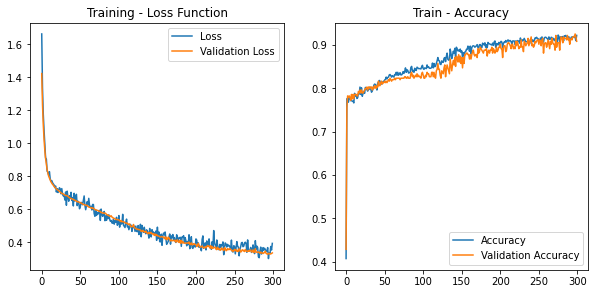

Draw decision region plots below!


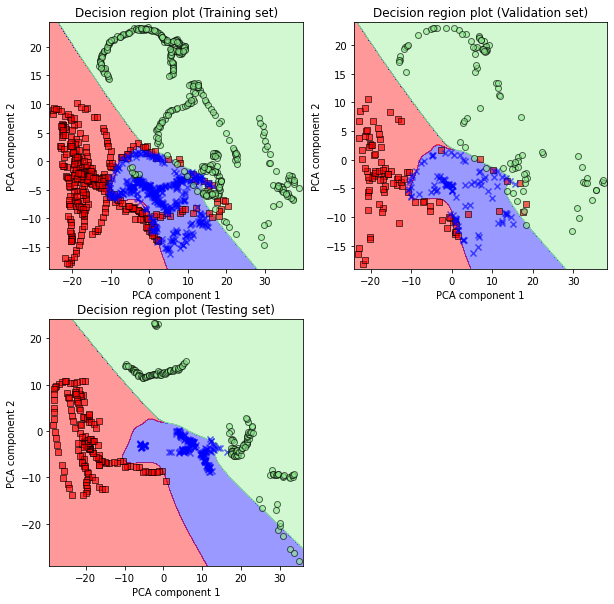

In [350]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
hidden_num_2 = 10
is_use_opt = False

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 5, hidden_num_2 = 10, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 2211.2892867892792, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 2, loss: 1987.1370305760638, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 3, loss: 1905.42380931676, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 4, loss: 1828.9537343160096, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 5, loss: 1801.0178172967453, Training acc: 0.32142857142857145, Val acc: 0.3197278911564626
epoch: 6, loss: 1756.8431563390682, Training acc: 0.4812925170068027, Val acc: 0.46258503401360546
epoch: 7, loss: 1734.5341205152797, Training acc: 0.6760204081632653, Val acc: 0.6360544217687075
epoch: 8, loss: 1696.5257397520882, Training acc: 0.7219387755102041, Val acc: 0.7074829931972789
epoch: 9, loss: 1673.038748621174, Training acc: 0.7066326530612245, Val acc: 0.7074829931972789
epoch: 10, loss: 1645.0674466747466, Training acc: 0.7100340136054422,

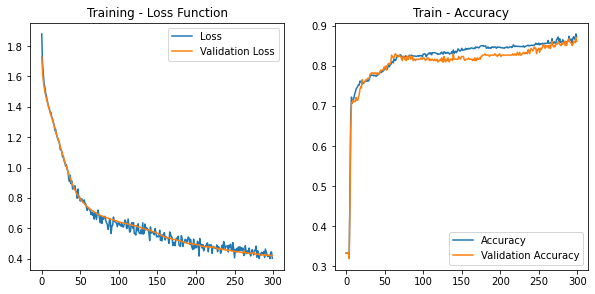

Draw decision region plots below!


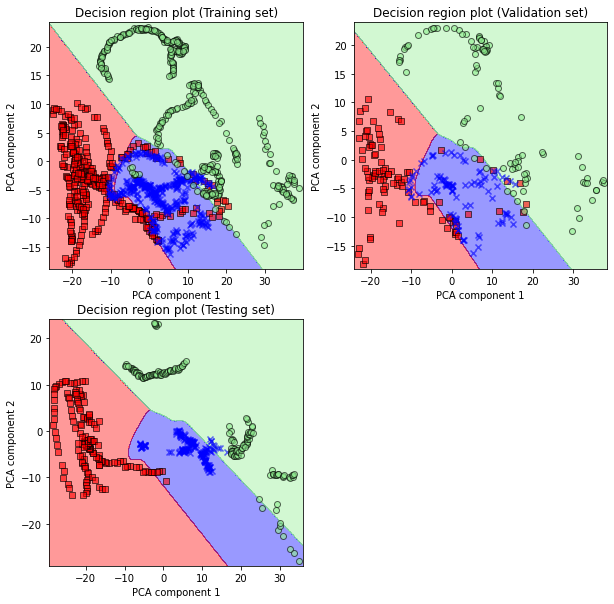

In [351]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 5, hidden_num_2 = 10, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1719.4298060326291, Training acc: 0.6386054421768708, Val acc: 0.6122448979591837
epoch: 2, loss: 1526.1996751692425, Training acc: 0.689625850340136, Val acc: 0.6564625850340136
epoch: 3, loss: 1409.1602635622369, Training acc: 0.6717687074829932, Val acc: 0.6666666666666666
epoch: 4, loss: 1330.2651274908574, Training acc: 0.7125850340136054, Val acc: 0.6904761904761905
epoch: 5, loss: 1298.021178028274, Training acc: 0.7491496598639455, Val acc: 0.7142857142857143
epoch: 6, loss: 1202.8058727814177, Training acc: 0.766156462585034, Val acc: 0.7687074829931972
epoch: 7, loss: 1157.4957946293002, Training acc: 0.7780612244897959, Val acc: 0.7857142857142857
epoch: 8, loss: 1112.4410015813348, Training acc: 0.7712585034013606, Val acc: 0.7755102040816326
epoch: 9, loss: 1127.7991193092055, Training acc: 0.7789115646258503, Val acc: 0.7755102040816326
epoch: 10, loss: 1068.2714728157866, Training acc: 0.7814625850340136, V

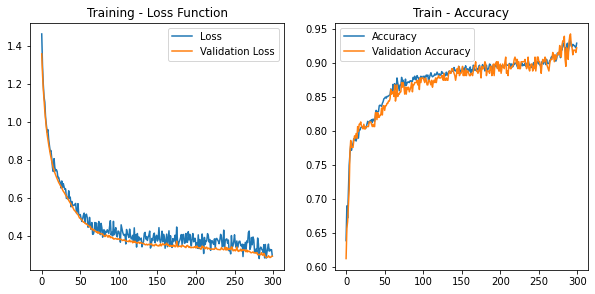

Draw decision region plots below!


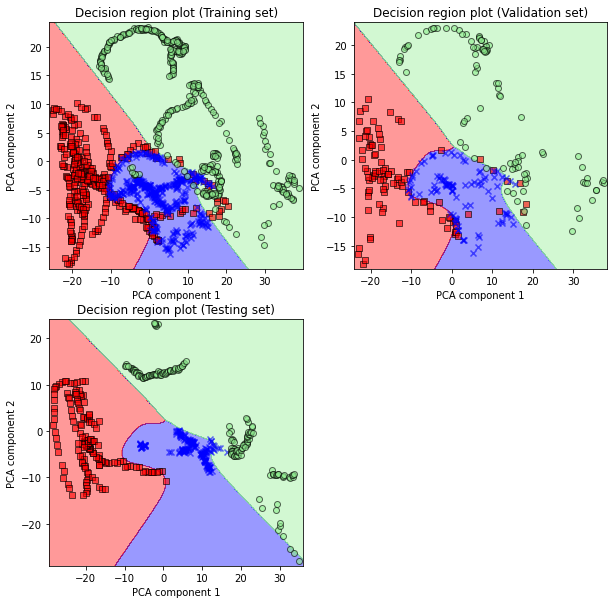

In [352]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 5
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 15, hidden_num_2 = 10, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 2325.677734230589, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 2, loss: 1859.2765910405085, Training acc: 0.3333333333333333, Val acc: 0.3333333333333333
epoch: 3, loss: 1762.940733159974, Training acc: 0.38860544217687076, Val acc: 0.3877551020408163
epoch: 4, loss: 1676.251550911307, Training acc: 0.5510204081632653, Val acc: 0.5374149659863946
epoch: 5, loss: 1598.1727064558997, Training acc: 0.6130952380952381, Val acc: 0.6224489795918368
epoch: 6, loss: 1571.6666721374663, Training acc: 0.6284013605442177, Val acc: 0.6360544217687075
epoch: 7, loss: 1498.3680018756036, Training acc: 0.6173469387755102, Val acc: 0.6258503401360545
epoch: 8, loss: 1485.167499944816, Training acc: 0.657312925170068, Val acc: 0.6428571428571429
epoch: 9, loss: 1398.914440618162, Training acc: 0.6768707482993197, Val acc: 0.6462585034013606
epoch: 10, loss: 1354.828600157471, Training acc: 0.689625850340136, Val a

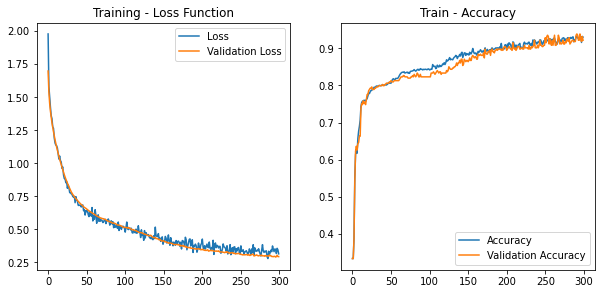

Draw decision region plots below!


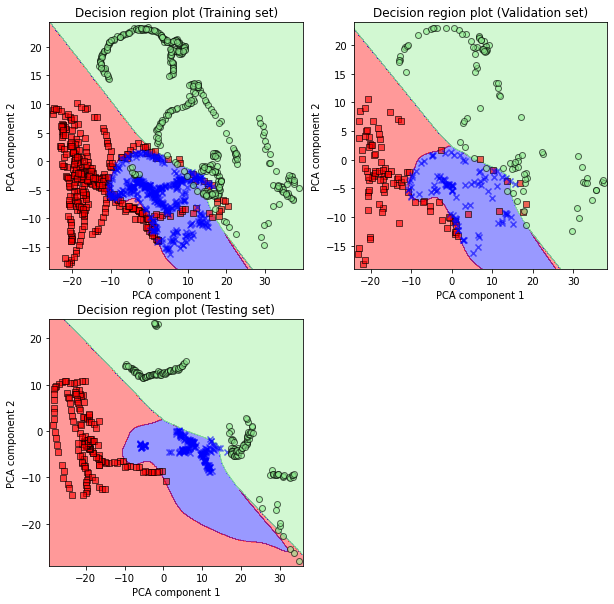

In [353]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 15, hidden_num_2 = 10, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1514.1598348705866, Training acc: 0.6539115646258503, Val acc: 0.6768707482993197
epoch: 2, loss: 1173.4408570246374, Training acc: 0.766156462585034, Val acc: 0.7517006802721088
epoch: 3, loss: 1073.9408155204164, Training acc: 0.7840136054421769, Val acc: 0.7687074829931972
epoch: 4, loss: 947.4185008732476, Training acc: 0.7874149659863946, Val acc: 0.7891156462585034
epoch: 5, loss: 913.2176072461735, Training acc: 0.79421768707483, Val acc: 0.8027210884353742
epoch: 6, loss: 913.5849418641619, Training acc: 0.79421768707483, Val acc: 0.8095238095238095
epoch: 7, loss: 895.3451880063059, Training acc: 0.8112244897959183, Val acc: 0.8129251700680272
epoch: 8, loss: 864.1455759191102, Training acc: 0.8231292517006803, Val acc: 0.8231292517006803
epoch: 9, loss: 819.725801557908, Training acc: 0.8282312925170068, Val acc: 0.8231292517006803
epoch: 10, loss: 791.24697871976, Training acc: 0.826530612244898, Val acc: 0.826

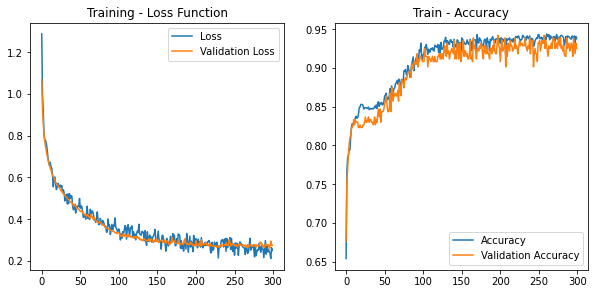

Draw decision region plots below!


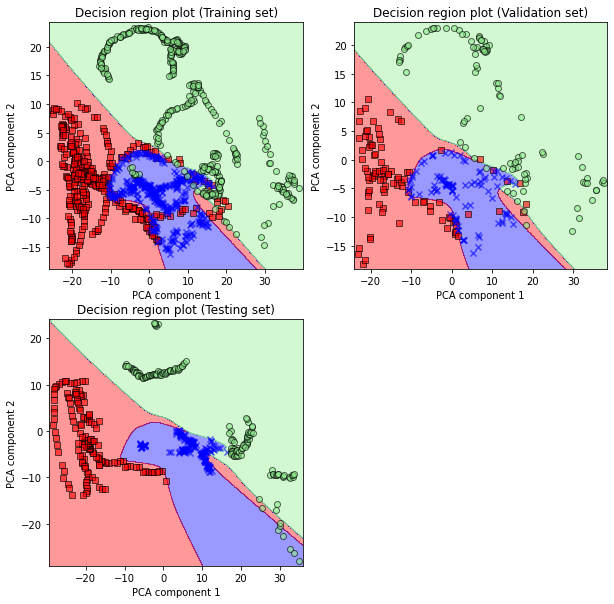

In [354]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 15
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 50, hidden_num_2 = 10, lr = 0.0003, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1703.892632246892, Training acc: 0.7627551020408163, Val acc: 0.7653061224489796
epoch: 2, loss: 1427.7256338093127, Training acc: 0.7491496598639455, Val acc: 0.7312925170068028
epoch: 3, loss: 1345.51700789501, Training acc: 0.7585034013605442, Val acc: 0.7551020408163265
epoch: 4, loss: 1278.1324508630944, Training acc: 0.7738095238095238, Val acc: 0.7789115646258503
epoch: 5, loss: 1255.9303282579388, Training acc: 0.7772108843537415, Val acc: 0.7789115646258503
epoch: 6, loss: 1172.4699784810603, Training acc: 0.7797619047619048, Val acc: 0.7789115646258503
epoch: 7, loss: 1168.7374829138978, Training acc: 0.7789115646258503, Val acc: 0.7857142857142857
epoch: 8, loss: 1086.323723481616, Training acc: 0.7865646258503401, Val acc: 0.7857142857142857
epoch: 9, loss: 1019.7235309620324, Training acc: 0.7916666666666666, Val acc: 0.7959183673469388
epoch: 10, loss: 1005.508845237957, Training acc: 0.7933673469387755, Val

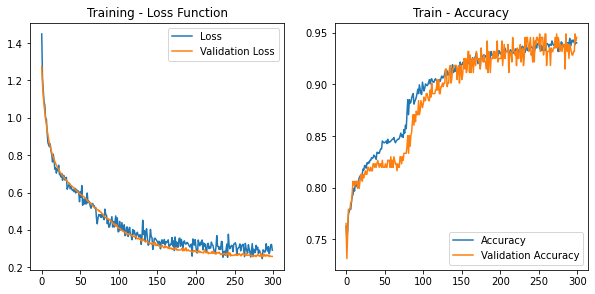

Draw decision region plots below!


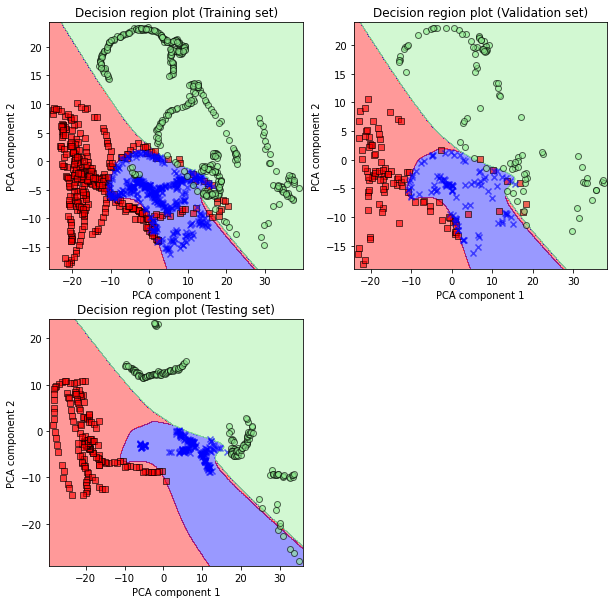

In [355]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.0003, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')


##### Training setting: hidden_num_1 = 50, hidden_num_2 = 10, lr = 0.001, use Adam technique to improve weight update

This is <class '__main__.three_layer_NN'> model.
epoch: 1, loss: 1310.2066999401377, Training acc: 0.7704081632653061, Val acc: 0.7789115646258503
epoch: 2, loss: 990.7996936787409, Training acc: 0.8010204081632653, Val acc: 0.8061224489795918
epoch: 3, loss: 936.915434143965, Training acc: 0.810374149659864, Val acc: 0.8163265306122449
epoch: 4, loss: 872.0730131043763, Training acc: 0.8163265306122449, Val acc: 0.8129251700680272
epoch: 5, loss: 829.1067807550528, Training acc: 0.8248299319727891, Val acc: 0.8163265306122449
epoch: 6, loss: 819.4750782848998, Training acc: 0.826530612244898, Val acc: 0.8197278911564626
epoch: 7, loss: 778.4183936647073, Training acc: 0.8324829931972789, Val acc: 0.8163265306122449
epoch: 8, loss: 766.245079870139, Training acc: 0.8341836734693877, Val acc: 0.8197278911564626
epoch: 9, loss: 759.7822179012686, Training acc: 0.8350340136054422, Val acc: 0.8197278911564626
epoch: 10, loss: 761.0414332569983, Training acc: 0.8392857142857143, Val acc: 0.

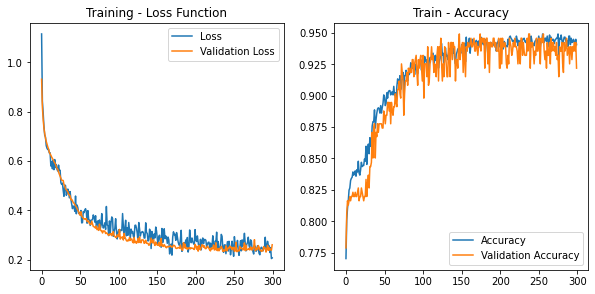

Draw decision region plots below!


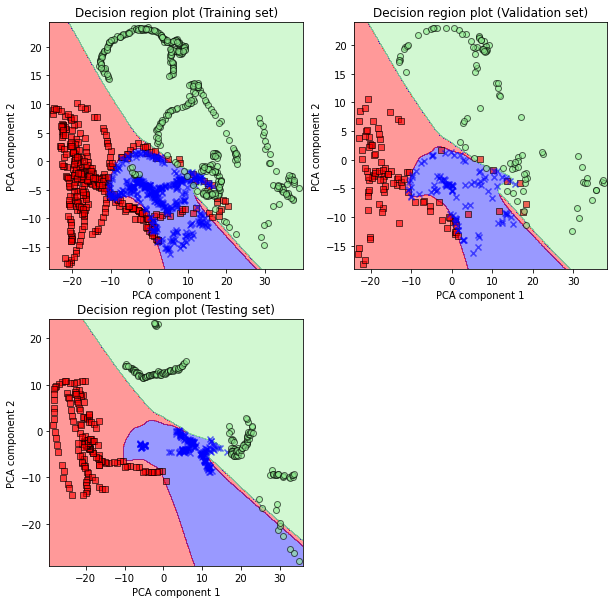

In [356]:
# define the hidden num and whether using optimizer or not
hidden_num_1 = 50
hidden_num_2 = 10
is_use_opt = True

model = three_layer_NN(lr=0.001, input_dim=3, hidden_1=hidden_num_1, hidden_2=hidden_num_2)

epoch = 300
loss_rec = []
acc_rec = []
val_acc_rec = []
val_loss_rec = []
train(use_opt=is_use_opt)

# draw learning curve
print('Draw learning curves below!')
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss_rec, label='Loss')
plt.plot(val_loss_rec, label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(acc_rec, label='Accuracy')
plt.plot(val_acc_rec, label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_decision_regions(X_train_pca, y_train, model)
plt.title('Decision region plot (Training set)')
plt.subplot(2, 2, 2)
plot_decision_regions(X_val_pca, y_val, model)
plt.title('Decision region plot (Validation set)')
plt.subplot(2, 2, 3)
plot_decision_regions(X_test_pca, y_test, model)
plt.title('Decision region plot (Testing set)')
print('Draw decision region plots below!')
